In [1]:
import pandas as pd
import numpy as np
from pickleshare import PickleShareDB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import time
import tracemalloc

In [2]:
# Pour garantir la reproductibilité
np.random.seed(42)  # Pour numpy

## Chargement des données

In [3]:
db = PickleShareDB('../prep_data/kity')
# sample_df = db['net_sample_for_models']
sample_df = db['pca_result_with_labels']

In [4]:
sample_df = sample_df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(frac=0.1, random_state=42)
)

/tmp/ipykernel_15865/3490013237.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_df = sample_df.groupby('label', group_keys=False).apply(
/tmp/ipykernel_15865/3490013237.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = sample_df.groupby('label', group_keys=False).apply(


Le type d'attaque 'scan' a tres peu d'entrees, ce qui empeche les modeles. On supprime ce type d'attaque.

In [5]:
to_drop = sample_df[sample_df['label'] == 'scan'].index
sample_df = sample_df.drop(to_drop)

In [6]:
labels = sample_df[['label', 'label_n']]
sample_df.drop(columns=['label', 'label_n'], inplace=True)

## Initialisation du modèle

In [7]:
# Initialiser le modèle Random Forest 
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

## Entraînement du modèle et évaluation - Classification binaire

In [8]:
X = sample_df
y_label_n = labels['label_n']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_label_n, test_size=0.2, random_state=42, stratify=y_label_n)

In [9]:
# Mesurer le temps et la mémoire pour l'entraînement
tracemalloc.start()
start_fit_time = time.time()

rf_model.fit(X_train, y_train)

fit_time = time.time() - start_fit_time
current, peak = tracemalloc.get_traced_memory()  # Mémoire actuelle et maximale utilisée
fit_memory_usage = peak / (1024 * 1024)  # Convertir en Mo
tracemalloc.stop()

In [10]:
# Mesurer le temps et la mémoire pour la prediction
tracemalloc.start()
start_predict_time = time.time()

# Prédire les étiquettes sur l'ensemble de test
y_pred = rf_model.predict(X_test)
predict_time = time.time() - start_predict_time
current, peak = tracemalloc.get_traced_memory()  # Mémoire actuelle et maximale utilisée
predict_memory_usage = peak / (1024 * 1024)  # Convertir en Mo
tracemalloc.stop()

### Évaluation

#### Métriques de classification

In [11]:
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

# Métriques pour les données équilibrées
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
tnr = TN / (TN + FP) if (TN + FP) != 0 else 0
fpr = FP / (FP + TN) if (FP + TN) != 0 else 0
accuracy = accuracy_score(y_test, y_pred)

# Métriques pour les données déséquilibrées
f1 = f1_score(y_test, y_pred, average='binary')
balanced_acc = balanced_accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

results_RF_label_n = {
    'data': 'NETW',
    'model_type': 'Random Forest',
    'attack_type': 'labeln',
    'confusion_matrix': cm,
    'precision': precision,
    'recall': recall,
    'tnr': tnr,
    'fpr': fpr,
    'accuracy': accuracy,
    'f1': f1,
    'balanced_accuracy': balanced_acc,
    'mcc': mcc,
    'fit_time': fit_time,
    'predict_time': predict_time,
    'fit_memory_usage': fit_memory_usage,
    'predict_memory_usage': predict_memory_usage
}

In [12]:
# Afficher les résultats
print("Évaluation complète du modèle:")
for metric, value in results_RF_label_n.items():
    print(f"{metric}: {value}")

Évaluation complète du modèle:
data: NETW
model_type: Random Forest
attack_type: labeln
confusion_matrix: [[41143   268]
 [11954 61521]]
precision: 0.995662658401981
recall: 0.8373052058523307
tnr: 0.9935282895848929
fpr: 0.0064717104151070974
accuracy: 0.8936162804867434
f1: 0.9096433640880057
balanced_accuracy: 0.9154167477186118
mcc: 0.8001125419060903
fit_time: 4.5234715938568115
predict_time: 0.15482497215270996
fit_memory_usage: 622.1480102539062
predict_memory_usage: 39.35727024078369


##### Matrice de confusion 

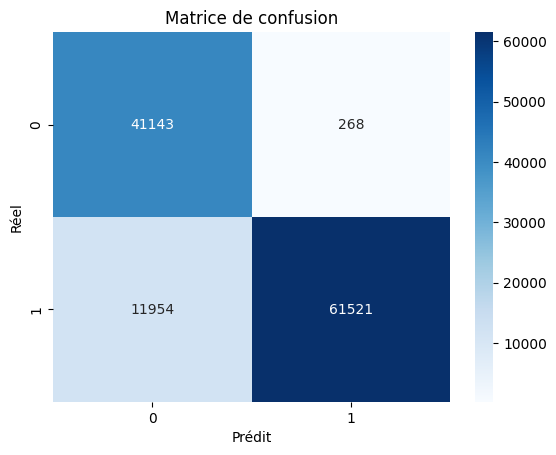

In [13]:
# Matrice de confusion
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

### Sauvegarder les resultats

In [14]:
# sauvegarder dans PickleShareDB
db['NETW_results_RF_labeln'] = results_RF_label_n

## Entraînement du modèle et évaluation - Classification multi-classes

In [15]:
y_label = labels['label']

ordered_classes = ['normal', 'DoS','physical fault', 'MITM', 'anomaly']
nb_class = 5

le = LabelEncoder()
le.classes_ = np.array(ordered_classes)
label_mapping_network = {label: encoded for label, encoded in zip(le.classes_, range(len(le.classes_)))}
y_label_encoded = le.transform(y_label)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_label_encoded, test_size=0.2, random_state=42, stratify=y_label_encoded)

In [16]:
# Mesurer le temps et la mémoire pour l'entraînement
tracemalloc.start()
start_fit_time = time.time()

rf_model.fit(X_train, y_train)

fit_time = time.time() - start_fit_time
current, peak = tracemalloc.get_traced_memory()  # Mémoire actuelle et maximale utilisée
fit_memory_usage = peak / (1024 * 1024)  # Convertir en Mo
tracemalloc.stop()

In [17]:
# Mesurer le temps et la mémoire pour la prediction
tracemalloc.start()
start_predict_time = time.time()

# Prédire les étiquettes sur l'ensemble de test
y_pred = rf_model.predict(X_test)
predict_time = time.time() - start_predict_time
current, peak = tracemalloc.get_traced_memory()  # Mémoire actuelle et maximale utilisée
predict_memory_usage = peak / (1024 * 1024)  # Convertir en Mo
tracemalloc.stop()

In [18]:
label_mapping_network

{np.str_('normal'): 0,
 np.str_('DoS'): 1,
 np.str_('physical fault'): 2,
 np.str_('MITM'): 3,
 np.str_('anomaly'): 4}

In [19]:
db['label_mapping_network'] = label_mapping_network

In [20]:
reverse_label_mapping = {v: k for k, v in label_mapping_network.items()}

### Évaluation

#### Métriques de classification

In [21]:
cm = confusion_matrix(y_test, y_pred)

# Dictionnaire pour stocker les résultats de chaque classe
class_results = {}

for class_label in range(nb_class):
    # Extraire la matrice de confusion pour la classe spécifique
    TP = cm[class_label, class_label]
    FP = sum(cm[:, class_label]) - TP
    FN = sum(cm[class_label, :]) - TP
    TN = cm.sum() - (TP + FP + FN)

    # Calcul des métriques pour chaque classe
    precision = precision_score(y_test, y_pred, average=None)[class_label]
    recall_tpr = recall_score(y_test, y_pred, average=None)[class_label]
    tnr = TN / (TN + FP) if (TN + FP) != 0 else 0
    fpr = FP / (FP + TN) if (FP + TN) != 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1 = f1_score(y_test, y_pred, average=None)[class_label]
    balanced_acc = (recall_tpr + tnr) / 2
    mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) if (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) != 0 else 0


# Stocker les résultats dans le dictionnaire
    class_results[class_label] = {
        'data': 'NETW',
        'model_type': 'Random Forest',
        'attack_type': reverse_label_mapping[class_label],
        'confusion_matrix': cm,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP,
        'precision': precision,
        'recall': recall_tpr,
        'f1': f1,
        'balanced_accuracy': balanced_acc,
        'mcc': mcc,
        'tnr': tnr,
        'fpr': fpr,
        'accuracy': accuracy,
        'fit_time': fit_time,
        'predict_time': predict_time,
        'fit_memory_usage': fit_memory_usage,
        'predict_memory_usage': predict_memory_usage
    }

# Afficher ou enregistrer les résultats pour chaque classe
print(class_results)

{0: {'data': 'NETW', 'model_type': 'Random Forest', 'attack_type': np.str_('normal'), 'confusion_matrix': array([[41224,    20,   109,    59,     0],
       [  107, 61418,     2,     2,     0],
       [ 6845,     0,    28,    12,     0],
       [ 4957,     0,     9,    93,     0],
       [    0,     1,     0,     0,     0]]), 'TN': np.int64(61565), 'FP': np.int64(11909), 'FN': np.int64(188), 'TP': np.int64(41224), 'precision': np.float64(0.7758643404287354), 'recall': np.float64(0.9954602530667439), 'f1': np.float64(0.8720503463958962), 'balanced_accuracy': np.float64(0.9166878530760946), 'mcc': np.float64(nan), 'tnr': np.float64(0.8379154530854452), 'fpr': np.float64(0.16208454691455482), 'accuracy': np.float64(0.8947043155824034), 'fit_time': 5.257185220718384, 'predict_time': 0.17771077156066895, 'fit_memory_usage': 529.6053581237793, 'predict_memory_usage': 83.16814041137695}, 1: {'data': 'NETW', 'model_type': 'Random Forest', 'attack_type': np.str_('DoS'), 'confusion_matrix': arra

/home/zoe/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_15865/3242702541.py:21: RuntimeWarning: overflow encountered in scalar multiply
  mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) if (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) != 0 else 0
/tmp/ipykernel_15865/3242702541.py:21: RuntimeWarning: invalid value encountered in sqrt
  mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) if (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) != 0 else 0
/home/zoe/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

In [22]:
# vérif
print(precision_score(y_test, y_pred, average=None))
for i in range(nb_class):
    print(f"Résultats pour la classe {i}: {class_results[i]['precision']}")
    print(f"avec calcul : {class_results[i]['TP'] / (class_results[i]['TP'] + class_results[i]['FP'])}")

[0.77586434 0.9996582  0.18918919 0.56024096 0.        ]
Résultats pour la classe 0: 0.7758643404287354
avec calcul : 0.7758643404287354
Résultats pour la classe 1: 0.9996581975618093
avec calcul : 0.9996581975618093
Résultats pour la classe 2: 0.1891891891891892
avec calcul : 0.1891891891891892
Résultats pour la classe 3: 0.5602409638554217
avec calcul : 0.5602409638554217
Résultats pour la classe 4: 0.0
avec calcul : nan


/home/zoe/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_15865/2575117206.py:5: RuntimeWarning: invalid value encountered in scalar divide
  print(f"avec calcul : {class_results[i]['TP'] / (class_results[i]['TP'] + class_results[i]['FP'])}")


In [23]:
tp = class_results[1]['TP']
fn = class_results[1]['FN']
print("test tpr", tp / (tp + fn))
print(class_results[1]['recall'])

test tpr 0.998195972630792
0.998195972630792


##### Matrice de confusion 

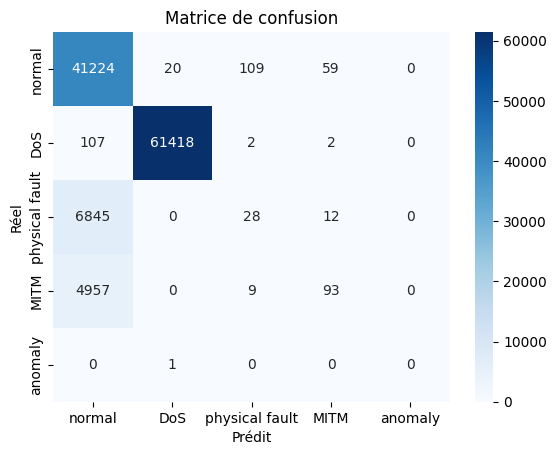

In [24]:
# Matrice de confusion
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ordered_classes, yticklabels=ordered_classes)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

### Sauvegarder les resultats

In [25]:
# sauvegarder les données 

for i in range(1, nb_class):
    class_results[i]['model'] = f'RF - label - {reverse_label_mapping[i]}'
    db[f'NETW_results_RF_{reverse_label_mapping[i]}'] = class_results[i]